Creating another variation on the initial data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [34]:
df = pd.read_csv("mdtraffic.csv")

## Drop columns unlikely to be useful

Too focused on timing or too fine grained or unique

In [36]:
df.columns

Index(['TMC', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng',
       'End_Lat', 'End_Lng', 'Distance(mi)', 'Description', 'Number', 'Street',
       'Side', 'City', 'County', 'State', 'Zipcode', 'Timezone',
       'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')

In [35]:
df.drop(["ID","Source","Country"],axis=1,inplace=True) # drop clearly unneeded columns

In [37]:
df["Zipcode"] = df.Zipcode.apply(lambda x: str(x).split("-")[0]) # fix zipcodes so that they are all 5 digit

In [38]:
df.drop(["End_Time","End_Lat","End_Lng"],axis=1,inplace=True) #can't know these things before it happens

In [39]:
df.drop(["Start_Lat","Start_Lng","State","City"],axis=1,inplace=True)# so much of location data is redundant and correlated

In [40]:
df.drop(["Timezone","Weather_Timestamp","Airport_Code","TMC","Description"],axis=1,inplace=True)

In [74]:
df.drop(["Start_Time","Zipcode","County","Number","Side"],axis=1,inplace=True)

## Street Type

In [41]:
df = df[~df.Street.str.contains("Francis Scott Key Bridge")]

In [42]:
print(df.Street.value_counts().shape)
df.Street.value_counts()

(5188,)


Street
I-95 N                 3287
I-95 S                 2959
Capital Beltway S      2342
Capital Beltway N      1678
I-695 E                1647
                       ... 
 Whaleyville Rd           1
 Executive Blvd           1
I-895B N                  1
 E Mount Harmony Rd       1
Emack Rd                  1
Name: count, Length: 5188, dtype: int64

In [43]:
def nsew(x,r):
    if x[-1] in ["N","S","E","W"]:
        r= r+x[-1]
    return r

In [44]:
def street_type(x):
    if "Tunl" in x or "Tunnel" in x:
        return "Tunnel"#nsew(x,"Tunnel")
    if "I-" in x:
        return "Interstate"
    if " Dr " in x or " Ave " in x or " Rd " in x or " Xing" in x or " Way " in x:
        return "local"
    if "Beltway" in x:
        return "Beltway"
    if "US-" in x[:4] or "MD-" in x[:4] or "Expy" in x:
        return "Highway"
    if "Hwy" in x or "Fwy" in x or "Highway" in x or "Route" in x or "Connector" in x or "Byp" in x or "Bypass" in x or "Gtwy" in x or "Brg" in x or "Trwy" in x:
        return "Highway"
    if x[-2:] in ["St","Pl","Dr","Sq"]:
        return "local"
    if "Ln" in x or "Rd" in x or "Ct" in x:
        return "local"
    if x[-3:] in ["Way","Cir","Ter","Trl","Plz","Aly","Grn","way","Ext"]:
        return "local"
    if "Ave" in x[-5:] or " Blvd" in x or " Pike" in x or "Pkwy" in x or "Crse" in x or "Alameda" in x:
        return "large_local"
    if "Garth" in x or "Spell" in x or "Psge" in x or "Chase" in x or "Cutoff" in x or "Spire" in x:
        return "local"
    if "Overlook" in x or "Battlefield" in x or "Cemetery" in x or "Park" in x or "Base" in x or "Concourse" in x or "Memorial" in x:
        return "special"
    if "Loop" in x or "Greenway" in x or "West" in x or "ville" in x or "wood" in x:
        return "local"
    
    return x

In [45]:
df["Street"] = df.Street.apply(street_type)

In [46]:
df=df.loc[~df.Street.str.contains("special")]

In [47]:
df.Street.value_counts()

Street
Interstate     18618
local          18323
large_local    13341
Highway        11607
Beltway         7031
Tunnel          1014
Name: count, dtype: int64

## Weather Condition

In [48]:
df["Weather_Condition"].value_counts()

Weather_Condition
Fair                            11776
Clear                            9368
Mostly Cloudy                    7676
Cloudy                           6853
Overcast                         5928
Partly Cloudy                    4177
Scattered Clouds                 3144
Light Rain                       2245
Rain                              716
Fog                               656
Light Snow                        457
Light Drizzle                     330
Haze                              183
Heavy Rain                        178
Fair / Windy                      115
Snow                              105
Mostly Cloudy / Windy              86
Partly Cloudy / Windy              69
Light Freezing Rain                64
Cloudy / Windy                     58
Drizzle                            57
T-Storm                            44
Shallow Fog                        38
Light Rain / Windy                 37
Wintry Mix                         36
Thunderstorm                    

In [49]:
df = df.loc[(df.Weather_Condition != "Sand")] # too few values

In [50]:
# missing values count as a float
# change to "unknown" instead. Later we can decide if we want to keep
df["Weather_Condition"] = df["Weather_Condition"].fillna("unknown")

In [51]:
df["Weather_Condition"] = df["Weather_Condition"].apply(lambda x: "None" if "N/A" in x else x)

In [52]:
df["Weather_Condition"]=df["Weather_Condition"].apply(lambda x: "Windy" if "Windy" in x else x)

In [53]:
def mapping_1(x):
    tomap = {"Light Drizzle":"Drizzle",
            "Light Rain with Thunder":"Light Thunderstorms and Rain",
            "Thunder in the Vicinity":"Thunder",
            "Heavy Drizzle":"Rain",
            "Mist":"Fog",
            "Light Freezing Drizzle":"Light Freezing Rain"}
    if x in tomap:
        return tomap[x]
    return x

In [54]:
def mapping_2(x):
    tomap = {"Light Rain Shower":"Drizzle",
             "Light Rain":"Drizzle",
            "Light Ice Pellets":"Ice Pellets",
            "Shallow Fog":"Fog"}
    if x in tomap:
        return tomap[x]
    return x

In [55]:
def mapping_3(x):
    tomap = {"Heavy Ice Pellets":"Ice Pellets",
            "Drizzle and Fog":"Fog",
            "Patches of Fog":"Fog",
            "Heavy Snow":"Snow",
            "Heavy Thunderstorms and Rain":"Thunderstorms",
            "T-Storm":"Thunderstorms",
            "Heavy T-Storm":"Thunderstorms",
            "Thunderstorms and Rain":"Thunderstorms"}
    if x in tomap:
        return tomap[x]
    return x

In [56]:
def mapping_4(x):
    tomap = {"Light Snow Shower":"Snow",
            "Light Snow":"Snow",
            "Light Rain Showers":"Drizzle",
            "Light Thunderstorms and Rain":"Thunderstorms"}
    if x in tomap:
        return tomap[x]
    return x

In [57]:
df["Weather_Condition"]=df["Weather_Condition"].apply(mapping_1)                        

In [58]:
df["Weather_Condition"]=df["Weather_Condition"].apply(mapping_2)

In [59]:
df["Weather_Condition"]=df["Weather_Condition"].apply(mapping_3)

In [60]:
df["Weather_Condition"]=df["Weather_Condition"].apply(mapping_4)

In [61]:
df.Weather_Condition.value_counts()

Weather_Condition
unknown                15201
Fair                   11776
Clear                   9368
Mostly Cloudy           7676
Cloudy                  6853
Overcast                5928
Partly Cloudy           4177
Scattered Clouds        3144
Drizzle                 2660
Fog                      734
Rain                     720
Snow                     579
Windy                    397
Haze                     183
Heavy Rain               178
Thunderstorms            136
Light Freezing Rain       67
Thunder                   44
Wintry Mix                36
Thunderstorm              31
Ice Pellets               29
Light Freezing Fog        10
None                       3
Light Sleet                1
Name: count, dtype: int64

None and Light Sleet have almost no rows will values, drop them.
Light Freezing Fog has 10 rows. Change to Fog.
Leave others for now. Will need to decide if further combinations are necessary.

In [63]:
df = df.loc[(df.Weather_Condition != "None") & (df.Weather_Condition != "Light Sleet")]

In [64]:
df=df.reset_index(drop=True)

In [65]:
df.shape

(69927, 34)

## Wind Direction

In [66]:
# Can decide later whether to keep or remove rows with unknown values
df["Wind_Direction"] = df.Wind_Direction.fillna("unknown")

In [67]:
df.Wind_Direction.value_counts()

Wind_Direction
unknown     8411
CALM        8262
North       7824
Calm        7413
WNW         4140
NW          3614
NNW         2521
SSW         2295
West        2145
SW          1960
W           1940
SSE         1878
S           1865
SE          1800
WSW         1767
NNE         1713
South       1599
NE          1491
N           1410
ENE         1372
ESE         1164
East        1021
E            850
VAR          775
Variable     697
Name: count, dtype: int64

In [68]:
# Basic cleanup of alternative spellings
def wind_map(x):
    tomap = {"CALM":"Calm","South":"S","West":"W","North":"N","East":"E","VAR":"Variable"}
    if x in tomap:
        return tomap[x]
    return x

In [69]:
# Less fine grained values
def wind_2(x):
    tomap = {"WNW":"NW","NNW":"NW","SSW":"SW","SSE":"SE","WSW":"SW","NNE":"NE","ENE":"NE","ESE":"SE"}
    if x in tomap:
        return tomap[x]
    return x

In [70]:
df["Wind_Direction"] = df.Wind_Direction.apply(wind_map)

In [71]:
df["Wind_Direction"] = df.Wind_Direction.apply(wind_2)

In [72]:
df.Wind_Direction.value_counts()

Wind_Direction
Calm        15675
NW          10275
N            9234
unknown      8411
SW           6022
SE           4842
NE           4576
W            4085
S            3464
E            1871
Variable     1472
Name: count, dtype: int64

## Missing Values: drop columns

In [75]:
df.columns

Index(['Severity', 'Distance(mi)', 'Street', 'Temperature(F)', 'Wind_Chill(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction',
       'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity',
       'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway',
       'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')

In [77]:
df.shape

(69927, 29)

In [76]:
df.isna().sum()

Severity                     0
Distance(mi)                 0
Street                       0
Temperature(F)            5948
Wind_Chill(F)            35083
Humidity(%)               6010
Pressure(in)              5561
Visibility(mi)           15111
Wind_Direction               0
Wind_Speed(mph)          22487
Precipitation(in)        37268
Weather_Condition            0
Amenity                      0
Bump                         0
Crossing                     0
Give_Way                     0
Junction                     0
No_Exit                      0
Railway                      0
Roundabout                   0
Station                      0
Stop                         0
Traffic_Calming              0
Traffic_Signal               0
Turning_Loop                 0
Sunrise_Sunset               4
Civil_Twilight               4
Nautical_Twilight            4
Astronomical_Twilight        4
dtype: int64

In [78]:
# half of the rows are missing wind chill. Better to just drop the column
df.drop(["Wind_Chill(F)"],axis=1,inplace=True)

In [79]:
# half of the rows are missing precipitation, and weather condition already
# covers that situation more or less. So drop
df.drop(["Precipitation(in)"],axis=1,inplace=True)

<Axes: >

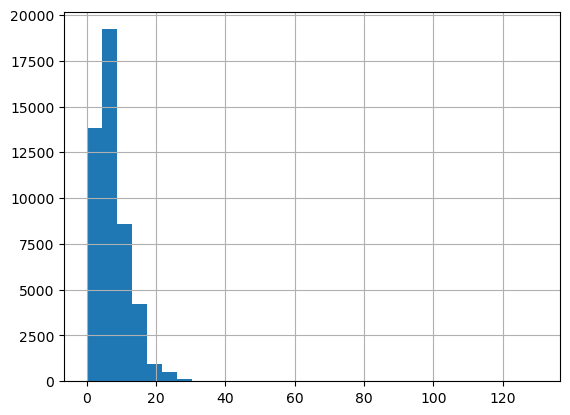

In [84]:
df["Wind_Speed(mph)"].hist(bins=30)

In [88]:
df[df["Wind_Speed(mph)"] > 40].shape[0]

11

Wind speed has a significant number of missing values. It is also a fairly tight distribution other than 11 values that are larger. Although wind speed could be useful in predicting severity, it may not be worth keeping in this situation. I think we try without it first.

In [89]:
df.drop(["Wind_Speed(mph)"],inplace=True,axis=1)

In [90]:
df.isna().sum()

Severity                     0
Distance(mi)                 0
Street                       0
Temperature(F)            5948
Humidity(%)               6010
Pressure(in)              5561
Visibility(mi)           15111
Wind_Direction               0
Weather_Condition            0
Amenity                      0
Bump                         0
Crossing                     0
Give_Way                     0
Junction                     0
No_Exit                      0
Railway                      0
Roundabout                   0
Station                      0
Stop                         0
Traffic_Calming              0
Traffic_Signal               0
Turning_Loop                 0
Sunrise_Sunset               4
Civil_Twilight               4
Nautical_Twilight            4
Astronomical_Twilight        4
dtype: int64

In [91]:
df.dropna().shape

(54243, 26)

It looks like dropping NA values doesn't remove too many rows, there must be rows with multiple NA values. So let's drop NA rows.

In [92]:
df.dropna(inplace=True)

## Twilights

We don't need four different twilights.

In [93]:
df.columns

Index(['Severity', 'Distance(mi)', 'Street', 'Temperature(F)', 'Humidity(%)',
       'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Weather_Condition',
       'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit',
       'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming',
       'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight',
       'Nautical_Twilight', 'Astronomical_Twilight'],
      dtype='object')

In [94]:
df.drop(['Civil_Twilight','Nautical_Twilight', 'Astronomical_Twilight'],inplace=True,axis=1)

## Any columns have too little info?

In [97]:
for col in ['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit',
       'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming',
       'Traffic_Signal', 'Turning_Loop']:
    print(df[col].value_counts())

Amenity
False    53968
True       275
Name: count, dtype: int64
Bump
False    54230
True        13
Name: count, dtype: int64
Crossing
False    51876
True      2367
Name: count, dtype: int64
Give_Way
False    54172
True        71
Name: count, dtype: int64
Junction
False    47466
True      6777
Name: count, dtype: int64
No_Exit
False    54201
True        42
Name: count, dtype: int64
Railway
False    54148
True        95
Name: count, dtype: int64
Roundabout
False    54241
True         2
Name: count, dtype: int64
Station
False    53671
True       572
Name: count, dtype: int64
Stop
False    53979
True       264
Name: count, dtype: int64
Traffic_Calming
False    54059
True       184
Name: count, dtype: int64
Traffic_Signal
False    47444
True      6799
Name: count, dtype: int64
Turning_Loop
False    54243
Name: count, dtype: int64


Bump, Give_Way, No_Exit, Roundabout, have almost no True values, so drop.
All values in Turning_Loop are identical, so drop.

In [99]:
df.drop(['Bump', 'Give_Way', 'No_Exit', 'Roundabout','Turning_Loop'],inplace=True,axis=1)

Will need to consider if it is worth keeping all of these or combining in some way.

In [100]:
df.columns

Index(['Severity', 'Distance(mi)', 'Street', 'Temperature(F)', 'Humidity(%)',
       'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Weather_Condition',
       'Amenity', 'Crossing', 'Junction', 'Railway', 'Station', 'Stop',
       'Traffic_Calming', 'Traffic_Signal', 'Sunrise_Sunset'],
      dtype='object')

In [101]:
df.shape

(54243, 18)

## Examine Severity

For our project we want to wait to decide what to do about imbalance, and wait to one hot encode. Code below considers these issues, but the dataset saved is the one that exists without changing Severity or one hot encoding anything.

In [103]:
df.Severity.value_counts()

Severity
2    31956
3    16250
4     5771
1      266
Name: count, dtype: int64

In [385]:
#df.Severity = df.Severity.apply(lambda x: 2 if x == 1 else x)

In [104]:
for c in df.columns:
    print(c)

Severity
Distance(mi)
Street
Temperature(F)
Humidity(%)
Pressure(in)
Visibility(mi)
Wind_Direction
Weather_Condition
Amenity
Crossing
Junction
Railway
Station
Stop
Traffic_Calming
Traffic_Signal
Sunrise_Sunset


In [105]:
df_ohe = pd.get_dummies(df,drop_first=True)

In [106]:
df_ohe.shape

(54243, 51)

In [107]:
df_ohe.columns

Index(['Severity', 'Distance(mi)', 'Temperature(F)', 'Humidity(%)',
       'Pressure(in)', 'Visibility(mi)', 'Amenity', 'Crossing', 'Junction',
       'Railway', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal',
       'Street_Highway', 'Street_Interstate', 'Street_Tunnel',
       'Street_large_local', 'Street_local', 'Wind_Direction_E',
       'Wind_Direction_N', 'Wind_Direction_NE', 'Wind_Direction_NW',
       'Wind_Direction_S', 'Wind_Direction_SE', 'Wind_Direction_SW',
       'Wind_Direction_Variable', 'Wind_Direction_W', 'Wind_Direction_unknown',
       'Weather_Condition_Cloudy', 'Weather_Condition_Drizzle',
       'Weather_Condition_Fair', 'Weather_Condition_Fog',
       'Weather_Condition_Haze', 'Weather_Condition_Heavy Rain',
       'Weather_Condition_Ice Pellets', 'Weather_Condition_Light Freezing Fog',
       'Weather_Condition_Light Freezing Rain',
       'Weather_Condition_Mostly Cloudy', 'Weather_Condition_Overcast',
       'Weather_Condition_Partly Cloudy', 'Weathe

In [ ]:
# Save dataset with 4 classes and 